In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import pickle
import seaborn as sns
from collections import Counter
import seaborn as sns

from utils import DataLoader, DataProcesser, label_plot

%load_ext autoreload
%autoreload 2

In [2]:
label_dic = {1: 'Still', 2: 'Walking', 3: 'Run', 4: 'Bike', 5: 'Car', 6: 'Bus', 7: 'Train', 8: 'Subway'}

# Data

In [3]:
with open('data/mid_res/data_detail_full.pickle', 'rb') as file:
    data = pickle.load(file)

In [4]:
# dp = DataProcesser.DataProcesser(data)
# dp.process_pipe()

In [6]:
# data.df.to_csv("data/mid_res/data_ft_v1.csv", header = True, index = False)

In [7]:
data.df = pd.read_csv('data/mid_res/data_ft_v1.csv')
dp = DataProcesser.DataProcesser(data)
dp.process_data_window()

In [5]:
# data.df.to_csv("data/mid_res/20210525_data_df.csv", header = True, index = False)
data.df = pd.read_csv("data/mid_res/20210525_data_df.csv")

# Feature

In [6]:
list(data.df)

['time',
 'label',
 'accuracy',
 'latitude',
 'longitude',
 'altitude',
 'num_gps',
 'num_wifi',
 'num_cells',
 'time_dlt',
 'valid_dlt',
 'east',
 'north',
 'east_dlt',
 'north_dlt',
 'east_speed',
 'north_speed',
 'speed',
 'speed_dif',
 'speed_dlt',
 'acc',
 'wifi_rssi_mode',
 'wifi_rssi_mean',
 'wifi_rssi_min',
 'wifi_rssi_max',
 'wifi_rssi_std',
 'wifi_freq_5ratio',
 'cells_ctype_mode',
 'cells_isRegistered_mean',
 'cells_asuLevel_mean',
 'cells_dbm_mean',
 'cells_level_mean',
 'cells_asuLevel_min',
 'cells_dbm_min',
 'cells_level_min',
 'cells_asuLevel_max',
 'cells_dbm_max',
 'cells_level_max',
 'cells_asuLevel_std',
 'cells_dbm_std',
 'gps_snr_mean',
 'gps_snr_min',
 'gps_snr_max',
 'gps_snr_std',
 'speed_log',
 'acc_wd_std',
 'speed_wd_std']

In [7]:
data.df['have_loc'] = data.df.apply(lambda x: 1 if x['accuracy'] > -1 else 0, axis = 1)
data.df['have_gps'] = data.df.apply(lambda x: 1 if x['num_gps'] > 0 else 0, axis = 1)
data.df['have_wifi'] = data.df.apply(lambda x: 1 if x['num_wifi'] > 0 else 0, axis = 1)
data.df['have_cells'] = data.df.apply(lambda x: 1 if x['num_cells'] > 0 else 0, axis = 1)

In [8]:
# location
data.df['speed_level'] = pd.cut(data.df['speed'], [float('-inf'), 1, 20, float('inf')], labels = [0, 1, 2]).cat.add_categories(-1).fillna(0).astype('int')
data.df['accuracy_level'] = pd.cut(data.df['accuracy'], [float('-inf'), 5, 10, float('inf')], labels = [0, 1, 2]).cat.add_categories(-1).fillna(0).astype('int')
data.df['speed_wd_max_log'] = np.log(data.df['speed']+1).rolling(20, center = True).max().fillna(method = 'ffill').fillna(method = 'bfill')
data.df['acc_wd_std_log'] = data.df.apply(lambda x: np.log(x['acc_wd_std']*100000 + 1), axis = 1)
# gps
data.df['num_gps_level'] = pd.cut(data.df['num_gps'], [0, 5, 10, 15, 50], labels = list(range(4))).cat.add_categories(-1).fillna(0).astype('int')
# wifi
data.df['wifi_freq_5ratio_level'] = pd.cut(data.df['wifi_freq_5ratio'], [round(t, 2) for t in list(np.linspace(-0.01, 1.01, 10))], labels = list(range(9))).cat.add_categories(-1).fillna(0).astype('int')
data.df['num_wifi_level'] = pd.cut(data.df['num_wifi'], [-1, 1.5, 50], labels = list(range(2))).cat.add_categories(-1).fillna(0).astype('int')
# cells
data.df['num_cells_level'] = pd.cut(data.df['num_cells'], [0, 1.5, 2.5, 3.5, 5.5, 10.5, 50], labels = list(range(6))).cat.add_categories(-1).fillna(0).astype('int')
data.df['cells_isRegistered_mean_level'] = pd.cut(data.df['cells_isRegistered_mean'], [0, 0.2, 0.5, 1.1], labels = list(range(3))).cat.add_categories(-1).fillna(0).astype('int')
data.df['cells_asuLevel_mean_level'] = pd.cut(data.df['cells_asuLevel_mean'], [-1, 15, 100], labels = list(range(2))).cat.add_categories(-1).fillna(0).astype('int')
data.df['cells_dbm_mean'] = data.df.apply(lambda x: x['cells_dbm_mean'] if x['cells_dbm_mean'] < 0 else np.nan, axis = 1)

In [10]:
data.df.groupby(['label']).mean()[['have_loc', 'have_gps', 'have_wifi', 'have_cells', 'num_cells_level']]

,have_loc,have_gps,have_wifi,have_cells,num_cells_level
label,,,,,
1,0.420463,0.665996,0.863730,0.800942,1.322074
2,0.858919,0.896046,0.626281,0.876163,1.814232
3,0.991414,0.998013,0.688405,0.895378,2.161960
4,0.986346,0.998467,0.478097,0.865719,2.039062
5,0.772167,0.795532,0.316166,0.955840,1.995356
6,0.842294,0.959617,0.868225,0.883397,1.501493
7,0.442756,0.623083,0.808383,0.779400,1.355203
8,0.295697,0.355932,0.850700,0.400007,0.744477


In [11]:
# Counter(data.df.cells_level_max)

In [12]:
t = np.array(data.df.groupby(['label', 'num_gps_level']).count()['time'].reset_index(drop = True)).reshape(4, -1)
pd.DataFrame(t, columns = list(label_dic.values()))/pd.DataFrame(t, columns = list(label_dic.values())).sum(axis = 0)

,Still,Walking,Run,Bike,Car,Bus,Train,Subway
0,0.381281,0.246610,0.145107,0.201840,0.147532,0.080310,0.218663,0.346823
1,0.001002,0.004811,0.080293,0.278141,0.002225,0.010664,0.258878,0.379142
2,0.191003,0.250398,0.494381,0.356198,0.135045,0.651852,0.414868,0.209126
3,0.426714,0.498181,0.280220,0.163822,0.715198,0.257175,0.107592,0.064909


In [ ]:
# label_plot.plot_label(data.df, col_name)

## Plot

In [21]:
col_have = 'have_loc'
col_name = 'speed'
df_plot = data.df[(data.df[col_have] == 1)]

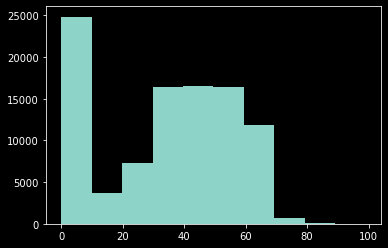

In [252]:
t = df_plot[(df_plot.label == 1)][col_name]
# t = df_plot[col_name]
plt.hist(t, bins = 10);

In [28]:
# sns.displot(t, kde = False)

In [49]:
df_plot['tmp'] = df_plot.apply(lambda x: int(x[col_name] > 0), axis = 1)

In [50]:
Counter(df_plot['tmp'])

Counter({0: 790617, 1: 670})

In [58]:
Counter(data.df['cells_level_min'])

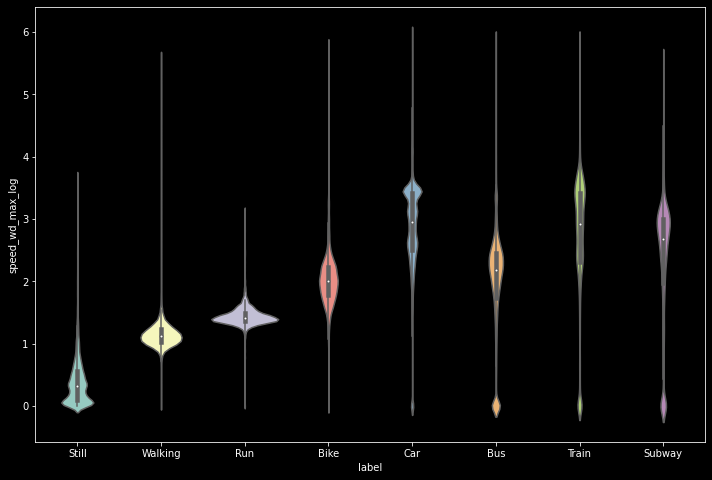

In [27]:
label_plot.box_label(df_plot, 'speed_wd_max_log', use_log = False, violin = True)

In [66]:
# label_plot.box_label(df_plot, 'acc_wd_std', use_log = True, violin = False)

In [65]:
# plt.figure(figsize = [12, 8])
# plt.subplot(1, 2, 1)
# plt.scatter(range(8), data.df[['label', col_name]].groupby('label').mean())
# plt.xticks(range(8), list(label_dic.values()));
# plt.subplot(1, 2, 2)
# data.df['tmp'] = data.df[['label', col_name]].rolling(10).std()[col_name]
# plt.scatter(range(8), data.df[['label', 'tmp']].groupby('label').std())
# plt.xticks(range(8), list(label_dic.values()));